# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

  Using cached https://files.pythonhosted.org/packages/31/9f/042db462417451e81035c3d43b722e88450c628a33dfda69777a801b0d40/scikit_learn-0.20.4-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/32/6b/0368cfa5e1d1ae169ab7dc78addda3fd5e6262e48d7373a9114bac7caff7/matplotlib-2.2.4-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 2.1MB 113kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1d/f6/7c16d60aeb3694e5611976cb4f1eaf1c6b7f1e7c55771d691013405a02ea/scipy-1.2.2-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d7/b1/3367ea1f372957f97a6752ec725b87886e12af1415216feec9067e31df70/numpy-1.16.5-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/03/8e/2424c0e65c4a066e28f539364de

In [98]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
from IPython.display import display

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [4]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [5]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [6]:
# Loading the dataset
# eg.
dirpath = os.path.join("datasets", "IMFDB")
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


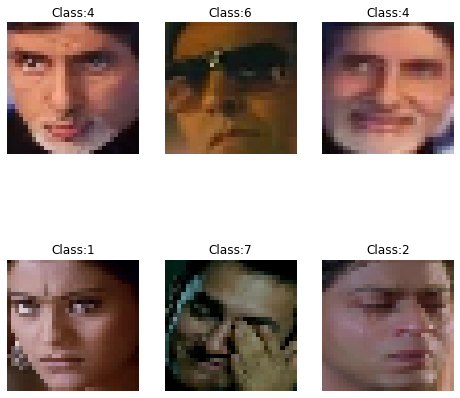

In [7]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [9]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return (X_k,pca)

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [10]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    
    """
    

    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True)
    X_k = kpca.fit_transform(X)
        
    
    return (X_k,kpca)

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [11]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    
    return (X_k,lda)

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [12]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    X_t=np.array(X.shape)
    if kernel == "poly":
        X_t = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_t=np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_t = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))    
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_t,y)
    
    return (X_k,klda)

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [13]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [14]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)

Eigen faces are the reconstructed faces obtained after performing pca and reverting back to the higher dimension each eigen face represents the image constructed only using that particular eigen vector. All the eigen faces summing up will give us the original image.The eigen face corresponding to eigen vectors of larger eigen values have higher contibution for the original image 

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [15]:
# Compute your features 
# eg.

dirpath = os.path.join("datasets", "IIIT-CFW")
X1,y1 = load_data(dirpath)
X1 = X1.reshape(672,3072)

dirpath = os.path.join("datasets", "Yale_face_database")
X2,y2 = load_data(dirpath)
X2 = X2.reshape(165,3072)


X_new = get_pca(X,3)
X_3D = X_new[0]
X_new1=get_pca(X1,3)
X_3D1=X_new1[0]
X_new2=get_pca(X2,3)
X_3D2=X_new2[0]

Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

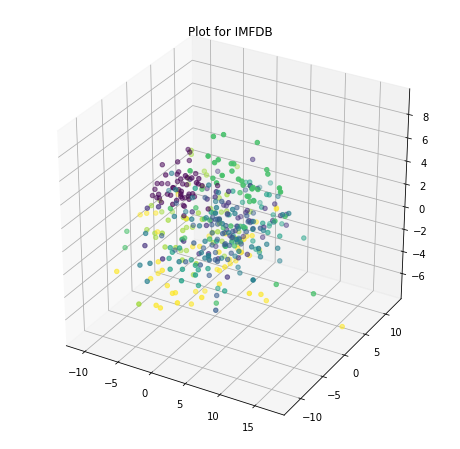

<Figure size 432x288 with 0 Axes>

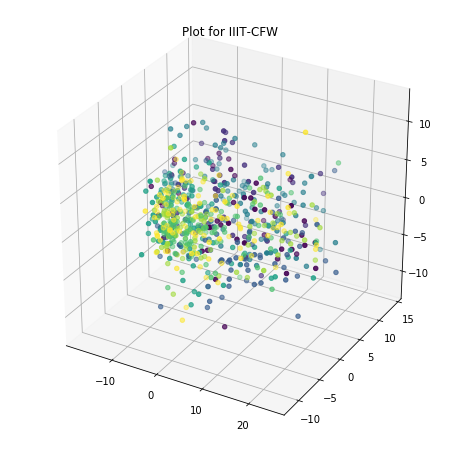

<Figure size 432x288 with 0 Axes>

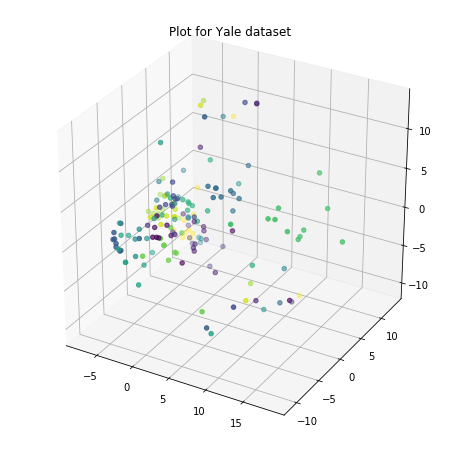

In [16]:
# Create a scatter plot  
# eg.
plt.figure(1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
plt.title("Plot for IMFDB")
plt.show()

plt.figure(2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D1[:,0],X_3D1[:,1],X_3D1[:,2],c=y1)
plt.title("Plot for IIIT-CFW")
plt.show()


plt.figure(3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D2[:,0],X_3D2[:,1],X_3D2[:,2],c=y2)
plt.title("Plot for Yale dataset")
plt.show()


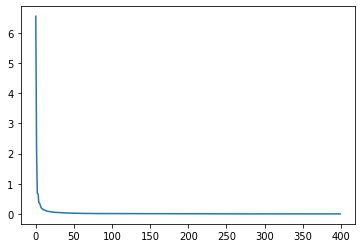

For IMFDB
Number of eigen vectors required for achieveing 80% similarity are: 16


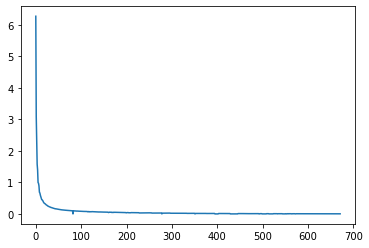

For CFW
Number of eigen vectors required for achieveing 80% similarity are: 142


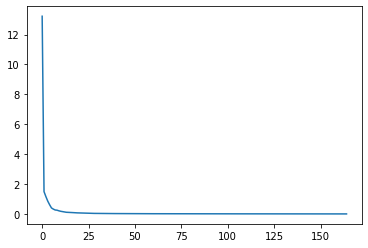

For Yale
Number of eigen vectors required for achieveing 80% similarity are: 5


In [17]:
# Plot the eigen value spectrum 
eig_val,eig_vec=np.linalg.eig(np.cov(X))
length=eig_val.shape[0]

plt.figure(1)
plt.plot(np.arange(length),eig_val)
plt.show()

s=0
ratio=0
netsum=np.sum(eig_val)
count=0
while(ratio<0.8):
    s=s+eig_val[count]
    count=count+1
    ratio=s/netsum
print("For IMFDB")    
print("Number of eigen vectors required for achieveing 80% similarity are:",count)


eig_val1,eig_vec1=np.linalg.eig(np.cov(X1))
length=eig_val1.shape[0]

plt.figure(2)
plt.plot(np.arange(length),eig_val1)
plt.show()

s=0
ratio=0
netsum=np.sum(eig_val1)
count=0
while(ratio<0.8):
    s=s+eig_val1[count]
    count=count+1
    ratio=s/netsum

print("For CFW")
print("Number of eigen vectors required for achieveing 80% similarity are:",count)



eig_val2,eig_vec2=np.linalg.eig(np.cov(X2))
length=eig_val2.shape[0]

plt.figure(3)
plt.plot(np.arange(length),eig_val2)
plt.show()

s=0
ratio=0
netsum=np.sum(eig_val2)
count=0
while(ratio<0.8):
    s=s+eig_val2[count]
    count=count+1
    ratio=s/netsum
print("For Yale")
print("Number of eigen vectors required for achieveing 80% similarity are:",count)

1(c). Reconstruct  the  image  back for each case


In [18]:
def reconstruct_images(data,label,k,*args,**kwargs):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    new_data,pca = get_pca(data,k)
    reconstruct_X=pca.inverse_transform(new_data)
        
    
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


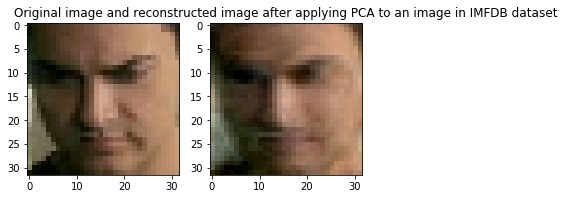

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


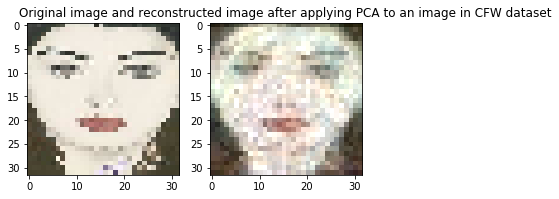

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


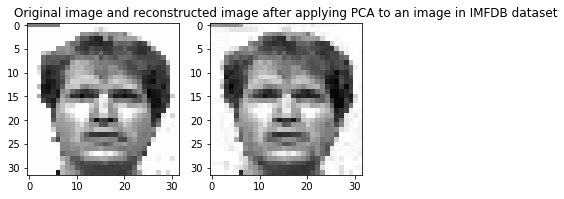

In [20]:
# #Display results 
# X_reconstruced = reconstruct_images()

# # Display random images
# # ind = np.random.randint(0,y.shape[0],6)
# # disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)

# # Show the reconstruction error
# print(np.sqrt(np.mean((X - X_reconstructed)**2)))


X=X.reshape(400,3072)
X1=X1.reshape(672,3072)
X2=X2.reshape(165,3072)
v=np.var(X)

X_new1=reconstruct_images(X,y,80)
X_new2=reconstruct_images(X1,y1,200)
X_new3=reconstruct_images(X2,y2,90)

X=X.reshape(400,32,32,3)
X1=X1.reshape(672,32,32,3)
X2=X2.reshape(165,32,32,3)
X_new1=X_new1.reshape(400,32,32,3)
X_new2=X_new2.reshape(672,32,32,3)
X_new3=X_new3.reshape(165,32,32,3)

plt.figure(1)
plt.subplot(1,2,1)    
plt.imshow(X[67])
plt.subplot(1,2,2)
plt.imshow(X_new1[67])
plt.title("Original image and reconstructed image after applying PCA to an image in IMFDB dataset")
plt.show()

plt.figure(2)
plt.subplot(1,2,1)    
plt.imshow(X1[120])
plt.subplot(1,2,2)
plt.imshow(X_new2[120])
plt.title("Original image and reconstructed image after applying PCA to an image in CFW dataset")
plt.show()


plt.figure(2)
plt.subplot(1,2,1)    
plt.imshow(X2[72])
plt.subplot(1,2,2)
plt.imshow(X_new3[72])
plt.title("Original image and reconstructed image after applying PCA to an image in IMFDB dataset")
plt.show()





1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [21]:
# code goes here
k_values=np.array([5,20,50,100])


X=X.reshape(400,3072)
X_new=np.zeros((400,3072))
labels=np.zeros(4)


for i in range(4):
    X_new=reconstruct_images(X,y,k_values[i])
    max_error=0
    for j in range(400):
        temp=X_new[j]-X[j]
        e=np.linalg.norm(temp,2)
        if(max_error < e):
            max_error=e
            labels[i]=y[j]
            
print(labels)
print("From the above labels of maximum error for different values of k, it can be deduced that 3th class having highest reconstruction error cannot be represented compactly with few eigen vectors")

X1=X1.reshape(672,3072)
X_new1=np.zeros((672,3072))
labels=np.zeros(4)


for i in range(4):
    X_new1=reconstruct_images(X1,y1,k_values[i])
    max_error=0
    for j in range(672):
        temp=X_new1[j]-X1[j]
        e=np.linalg.norm(temp,2)
        if(max_error < e):
            max_error=e
            labels[i]=y1[j]
            
print(labels)
print("From the above labels of maximum error for different values of k, it can be deduced that 6th class having highest reconstruction error cannot be represented compactly with few eigen vectors")


X2=X2.reshape(165,3072)
X_new2=np.zeros((165,3072))
labels=np.zeros(4)


for i in range(4):
    X_new2=reconstruct_images(X2,y2,k_values[i])
    max_error=0
    for j in range(165):
        temp=X_new2[j]-X2[j]
        e=np.linalg.norm(temp,2)
        if(max_error < e):
            max_error=e
            labels[i]=y2[j]
            
print(labels)
print("From the above labels of maximum error for different values of k, it can be deduced that 10th class having highest reconstruction error cannot be represented compactly with few eigen vectors")


        
    







[5. 3. 3. 0.]
From the above labels of maximum error for different values of k, it can be deduced that 3th class having highest reconstruction error cannot be represented compactly with few eigen vectors
[4. 6. 6. 7.]
From the above labels of maximum error for different values of k, it can be deduced that 6th class having highest reconstruction error cannot be represented compactly with few eigen vectors
[10. 10. 14.  5.]
From the above labels of maximum error for different values of k, it can be deduced that 10th class having highest reconstruction error cannot be represented compactly with few eigen vectors


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [28]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,m):
        self.method=m
#         super.__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """

        
        
        prediction = self.model.predict(X)
        
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        op=precision_recall_fscore_support(y, pred,average='micro')
        
        print("Precision:",op[0])
        print("Recall:",op[1])
        print("F1 score:",op[2])
        
    
        
        return cm(y,pred)
        
        
        
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        if(self.method=="MLP"):
            
            mlp = MLPClassifier(max_iter=1500) 
            mlp.fit(X_train, y_train)
            self.model=mlp

        
        elif(self.method=="LR"):
            
    
            logreg = lr(C=1e5, solver='lbfgs', multi_class='multinomial',max_iter=1500)
            logreg.fit(X_train,y_train)
            self.model=logreg

        
        elif(self.method=="SVM"):
        
            clf = SVC(kernel='rbf') 
            clf.fit(X_train, y_train) 
            self.model=clf
            
        elif(self.method=="DTrees"):

            clf = tree.DecisionTreeClassifier()
            clf=clf.fit(X_train, y_train)
            self.model=clf
        
        
            
        
        
        
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        print("Score: %f" % self.model.score(X_validate,y_validate))
        
        self.acc=self.model.score(X_validate,y_validate)

        # Create a confusion matrix
        
        # Calculate Validation accuracy 
    
        # Calculate precision and recall 
        
        # Calculate F1-score
    
    
    
    def f1(self,pred,y):
    
        self.f1=f1_score(y, pred,average='micro')
        
    
        return
    
    

In [29]:
# Create a train and validation split to train your classifier 

X=X.reshape(400,3072)
X1=X1.reshape(672,3072)
X2=X2.reshape(165,3072)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)


c=Classifier('MLP')
c.train(X_train,y_train)
c.validate(X_test,y_test)
p=c.classify(X_test)
c.confusion_matrix(p,y_test)

Score: 0.816667
Precision: 0.8166666666666667
Recall: 0.8166666666666667
F1 score: 0.8166666666666667


array([[16,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4,  3,  0,  1,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0],
       [ 1,  3,  0, 12,  0,  1,  1,  0],
       [ 0,  1,  0,  0, 15,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 11,  1,  1],
       [ 0,  1,  0,  1,  0,  0, 16,  0],
       [ 0,  0,  0,  1,  0,  1,  3, 14]])

In [36]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
# Print the table. (You can use Pandas)

X = X.reshape((400,3072))
X1=X1.reshape((672,3072))
X2=X2.reshape((165,3072))

columns=['Features used','Dimension Space','Classification error', 'Accuracy','F1score' ]
index=['1','2','3','4','5']

path1=os.path.join("datasets", "IMFDB")
path2=os.path.join("datasets","IIIT-CFW")
path3=os.path.join("datasets","Yale_face_database")



pca1,_=get_pca(X,100)
vgg2=get_vgg_features(path2)
resnet3=get_resnet_features(path3)


vgg_train2, vgg_test2, vgglabel_train2, vgglabel_test2 = train_test_split(vgg2, y1, test_size=0.2, random_state=42)
resnet_train3,resnet_test3,resnetlabel_train3,resnetlabel_test3=train_test_split(resnet3,y2,test_size=0.2,random_state=40)
pca_train1,pca_test1,pcalabel_train1,pcalabel_test1=train_test_split(pca1,y,test_size=0.2,random_state=4)


f11=np.zeros(3)
a1=np.zeros(3)
f12=np.zeros(3)                                                                    
a2=np.zeros(3)
f13=np.zeros(3)                                                       
a3=np.zeros(3)                                                
                                                                     
                                                                                                                                        
                                                                     
m=Classifier('MLP')
m.train(pca_train1,pcalabel_train1)
m.validate(pca_test1,pcalabel_test1)
a1[0]=m.acc
p=m.classify(pca_test1)
m.f1(p,pcalabel_test1)
f11[0]=m.f1                                                                     
                                                                     
                                                                     
                                                                     
m=Classifier('SVM')
m.train(pca_train1,pcalabel_train1)
m.validate(pca_test1,pcalabel_test1)
a1[1]=m.acc
p=m.classify(pca_test1)
m.f1(p,pcalabel_test1)
f11[1]=m.f1
                                                                     
                                                                     
m=Classifier('LR')
m.train(pca_train1,pcalabel_train1)
m.validate(pca_test1,pcalabel_test1)
a1[2]=m.acc
p=m.classify(pca_test1)
m.f1(p,pcalabel_test1)
f11[2]=m.f1                                                                



m=Classifier('DTrees')
m.train(vgg_train2,vgglabel_train2)
m.validate(vgg_test2,vgglabel_test2)
a2[0]=m.acc
p=m.classify(vgg_test2)
m.f1(p,vgglabel_test2)
f12[0]=m.f1
                                                                     
m=Classifier('SVM')
m.train(vgg_train2,vgglabel_train2)
m.validate(vgg_test2,vgglabel_test2)
a2[1]=m.acc
p=m.classify(vgg_test2)
m.f1(p,vgglabel_test2)
f12[1]=m.f1
                                                                     
m=Classifier('LR')
m.train(vgg_train2,vgglabel_train2)
m.validate(vgg_test2,vgglabel_test2)
a2[2]=m.acc
p=m.classify(vgg_test2)
m.f1(p,vgglabel_test2)
f12[2]=m.f1
                                                                     
                                                                     

m=Classifier('SVM')
m.train(resnet_train3,resnetlabel_train3)
m.validate(resnet_test3,resnetlabel_test3)
a3[0]=m.acc
p=m.classify(resnet_test3)
m.f1(p,resnetlabel_test3)
f13[0]=m.f1

m=Classifier('MLP')
m.train(resnet_train3,resnetlabel_train3)
m.validate(resnet_test3,resnetlabel_test3)
a3[1]=m.acc
p=m.classify(resnet_test3)
m.f1(p,resnetlabel_test3)
f13[1]=m.f1
                                                                     
m=Classifier('DTrees')
m.train(resnet_train3,resnetlabel_train3)
m.validate(resnet_test3,resnetlabel_test3)
a3[2]=m.acc
p=m.classify(resnet_test3)
m.f1(p,resnetlabel_test3)
f13[2]=m.f1

                                                                     
                                                                     
                                                                    
                                                                     
data1=[['pca(MLP)',100,1-a1[0],a1[0],f11[0]],['pca(SVM)',100,1-a1[1],a1[1],f11[1]],['pca(LR)',100,1-a1[2],a1[2],f11[2]]]
data2=[['vgg(DTrees)',4096,1-a2[0],a2[0],f12[0]],['vgg(SVM)',4096,1-a2[1],a2[1],f12[1]],['vgg(LR)',4096,1-a2[2],a2[2],f12[2]]]
data3=[['resnet(SVM)',2048,1-a3[0],a3[0],f13[0]],['resnet(MLP)',2048,1-a3[1],a3[0],f13[1]],['resnet(DTrees)',2048,1-a3[2],a3[2],f13[2]]]

op1=pd.DataFrame(data=data1,columns=columns)
display(op1)
op2=pd.DataFrame(data=data2,columns=columns)
display(op2)
op3=pd.DataFrame(data=data3,columns=columns)
display(op3)



Score: 0.837500
Score: 0.787500
Score: 0.787500


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.644444


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.659259


/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.674074
Score: 0.969697
Score: 0.969697
Score: 0.787879


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,pca(MLP),100,0.1625,0.8375,0.8375
1,pca(SVM),100,0.2125,0.7875,0.7875
2,pca(LR),100,0.2125,0.7875,0.7875


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,vgg(DTrees),4096,0.355556,0.644444,0.644444
1,vgg(SVM),4096,0.340741,0.659259,0.659259
2,vgg(LR),4096,0.325926,0.674074,0.674074


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,resnet(SVM),2048,0.030303,0.969697,0.969697
1,resnet(MLP),2048,0.030303,0.969697,0.969697
2,resnet(DTrees),2048,0.212121,0.787879,0.787879


In [32]:
# For each dataset print the confusion matrix for the best model 

models=['MLP','SVM','LR','DTrees']




acc1_max=0
for m in models:
    c=Classifier(m)
    c.train(X_train,y_train)
    c.validate(X_test,y_test)
    p=c.classify(X_test)  
    if(c.acc>acc1_max):
        cm1=c.confusion_matrix(p,y_test)
        acc1_max=c.acc
        best1=m
    
acc2_max=0
for m in models:
    c=Classifier(m)
    c.train(X_train1,y_train1)
    c.validate(X_test1,y_test1)
    p=c.classify(X_test1)  
    if(c.acc>acc2_max):
        cm2=c.confusion_matrix(p,y_test1)
        acc2_max=c.acc
        best2=m
        
acc3_max=0
for m in models:
    c=Classifier(m)
    c.train(X_train2,y_train2)
    c.validate(X_test2,y_test2)
    p=c.classify(X_test2)  
    if(c.acc>acc3_max):
        cm3=c.confusion_matrix(p,y_test2)
        acc3_max=c.acc
        best3=m
    







Score: 0.825000
Precision: 0.825
Recall: 0.825
F1 score: 0.825


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.258333
Score: 0.808333
Score: 0.458333
Score: 0.524752
Precision: 0.5247524752475248
Recall: 0.5247524752475248
F1 score: 0.5247524752475248


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.376238
Score: 0.504950
Score: 0.346535
Score: 0.900000
Precision: 0.9
Recall: 0.9
F1 score: 0.9


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.200000
Score: 0.840000
Score: 0.600000


In [35]:
print("Best model for IMFDB:",best1)
print("Accuracy:",acc1_max)
print("Confusion Matrix")
print(cm1)

print("Best model for CFW:",best2)
print("Accuracy:",acc2_max)
print("Confusion Matrix")
print(cm2)

print("Best model for Yale:",best3)
print("Accuracy:",acc3_max)
print("Confusion Matrix")
print(cm3)



Best model for IMFDB: MLP
Accuracy: 0.825
Confusion Matrix
[[16  0  0  0  0  0  0  0]
 [ 1  4  3  0  1  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 2  4  0 11  0  1  0  0]
 [ 0  1  0  0 15  0  0  0]
 [ 1  0  0  0  0 11  1  1]
 [ 0  1  0  1  0  0 16  0]
 [ 0  0  0  0  0  1  2 16]]
Best model for CFW: MLP
Accuracy: 0.5247524752475248
Confusion Matrix
[[ 6  2  0  4  1  0  0  1]
 [ 3  6  0  0  3  0  0  1]
 [ 1  1 11  2  5  0  2  6]
 [ 4  7  1 27  1  1  0  0]
 [ 0  1  3  1 13  2  0  5]
 [ 0  0  1  2  0 13  0  9]
 [ 0  0  2  1  3  0 14  1]
 [ 0  2  6  3  3  3  2 16]]
Best model for Yale: MLP
Accuracy: 0.9
Confusion Matrix
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [1 0 0 0 0 0 0 1 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

<Figure size 432x288 with 0 Axes>

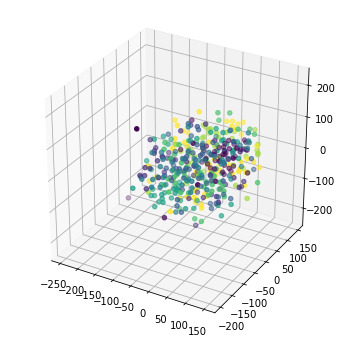

<Figure size 432x288 with 0 Axes>

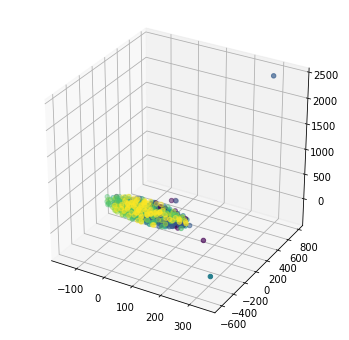

<Figure size 432x288 with 0 Axes>

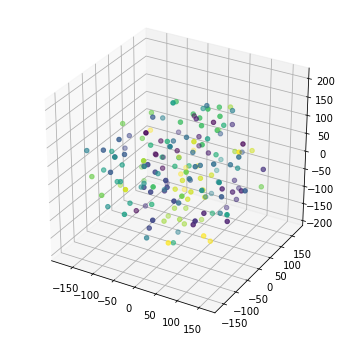

<Figure size 432x288 with 0 Axes>

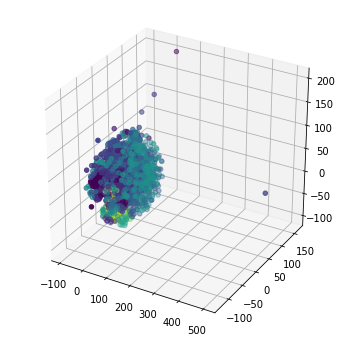

In [38]:
# Compute TSNE for different features and create a scatter plot
 
k = 3 
# Number of components in TSNE

# Compute

T1 = TSNE(n_components=3).fit_transform(X)
T2 = TSNE(n_components=3).fit_transform(X1)
T3=  TSNE(n_components=3).fit_transform(X2)
T4=  TSNE(n_components=3).fit_transform(np.concatenate((X,X1,X2),axis=0))



plt.figure(1)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T1[:,0],T1[:,1],T1[:,2],c=y)
plt.show()

plt.figure(2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T2[:,0],T2[:,1],T2[:,2],c=y1)
plt.show()


plt.figure(3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T3[:,0],T3[:,1],T3[:,2],c=y2)
plt.show()

plt.figure(4)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T4[:,0],T4[:,1],T4[:,2],c=np.concatenate((y,y1,y2),axis=0))
plt.show()




# Plot the representation in 2d/3d


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [58]:
class FaceVerification():
    def __init__():
        super.__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
        self.neighbors=11
    
    
    def verify(self,X,class_id,c):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        
        if(X.shape[0]==1):
            return self.model.predict(X.reshape(1,-1))==class_id
        else:
            verfication_results=np.zeros(X.shape[0])
        
            for i in range(X.shape[0]):

                temp=X[i]
                temp=temp.reshape(1,-1)
                l=c.predict(temp)
                if(l==class_id[i]):
                    verfication_results[i]=True
                else:
                    verfication_results[i]=False
        
            return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
        classifier = KNeighborsClassifier(n_neighbors=self.neighbors)
        classifier.fit(X_train, y_train)
        
        self.model=classifier
        
        return classifier
        

        
        
    def validate(self,X_validate,y_validate):
        
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label

        """
        
        self.accuracy=self.model.score(X_validate,y_validate)
        print(self.model.score(X_validate,y_validate))
    
    def classify(self,X):
 
        prediction = self.model.predict(X)

        return prediction
    
    def fs(self,pred,y):
        self.f1=f1_score(y, pred,average='micro')
        return
        
        

In [59]:
# Create a train and validation split and show your results 

X=X.reshape(400,3072)
X1=X1.reshape(672,3072)
X2=X2.reshape(165,3072)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


f=FaceVerification
f.neighbors=5
model=f.train(f,X_train,y_train)
print("Accuracy on IMFDB")
f.validate(f,X_train,y_train)


f=FaceVerification
f.neighbors=5
model=f.train(f,X_train1,y_train1)
print("Accuracy on CFW")
f.validate(f,X_test1,y_test1)


f=FaceVerification
f.neighbors=5
model=f.train(f,X_train2,y_train2)
print("Accuracy on Yale face database")
f.validate(f,X_test2,y_test2)





Accuracy on IMFDB
0.69375
Accuracy on CFW
0.2962962962962963
Accuracy on Yale face database
0.7272727272727273


In [66]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision


model1=FaceVerification
model1.neighbors=7
model1.train(model1,pca_train1,pcalabel_train1)
model1.validate(model1,pca_test1,pcalabel_test1)
a1=model1.accuracy
p=model1.classify(model1,pca_test1)
model1.fs(model1,p,pcalabel_test1)



model2=FaceVerification
model2.neighbors=5
model2.train(model2,pca_train1,pcalabel_train1)
model2.validate(model2,pca_test1,pcalabel_test1)
a2=model2.accuracy
p=model2.classify(model2,pca_test1)
model2.fs(model2,p,pcalabel_test1)



model3=FaceVerification
model3.neighbors=9
model3.train(model3,vgg_train2,vgglabel_train2)
model3.validate(model3,vgg_test2,vgglabel_test2)
a3=model3.accuracy
p=model3.classify(model3,vgg_test2)
model3.fs(model3,p,vgglabel_test2)

model4=FaceVerification
model4.neighbors=5
model4.train(model4,vgg_train2,vgglabel_train2)
model4.validate(model4,vgg_test2,vgglabel_test2)
a4=model4.accuracy
p=model4.classify(model4,vgg_test2)
model4.fs(model4,p,vgglabel_test2)


model5=FaceVerification
model5.neighbors=7
model5.train(model5,resnet_train3,resnetlabel_train3)
model5.validate(model5,resnet_test3,resnetlabel_test3)
a5=model5.accuracy
p=model5.classify(model5,resnet_test3)
model5.fs(model5,p,resnetlabel_test3)



model6=FaceVerification
model1.neighbors=9
model6.train(model6,resnet_train3,resnetlabel_train3)
model6.validate(model6,resnet_test3,resnetlabel_test3)
a6=model6.accuracy
p=model6.classify(model6,resnet_test3)
model6.fs(model6,p,resnetlabel_test3)



data1=[['pca(K=7)',4096,1-a1,a1,model1.f1],['pca(K=5)',100,1-a2,a2,model2.f1]]
data2=[['vgg(K=9)',2048,1-a3,a3,model3.f1],['vgg(K=5)',4096,1-a4,a4,model4.f1]]
data3=[['resnet(K=7)',100,1-a5,a5,model5.f1],['resnet(K=9)',2048,1-a6,a6,model6.f1]]

op1=pd.DataFrame(data=data1,columns=columns)
display(op1)
op2=pd.DataFrame(data=data2,columns=columns)
display(op2)
op3=pd.DataFrame(data=data3,columns=columns)
display(op3)



# Print the table. (You can use Pandas)

0.625
0.6625
0.6962962962962963
0.6814814814814815
0.9696969696969697
0.9696969696969697


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,pca(K=7),4096,0.3750,0.6250,0.969697
1,pca(K=5),100,0.3375,0.6625,0.969697


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,vgg(K=9),2048,0.303704,0.696296,0.969697
1,vgg(K=5),4096,0.318519,0.681481,0.969697


,Features used,Dimension Space,Classification error,Accuracy,F1score
0,resnet(K=7),100,0.030303,0.969697,0.969697
1,resnet(K=9),2048,0.030303,0.969697,0.969697


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [111]:
# Load data
dirpath = os.path.join("datasets", "IIIT-CFW")
X1,y1 = load_data(dirpath)

X1=X1.reshape(672,3072)

X=np.zeros((672,3072))
Y=np.zeros(672)

count=0
# 1 is for actor
# 0 is for politician


for i in range(X1.shape[0]):
    if(y1[i]==0 or y1[i]==1 or y1[i]== 2 or y1[i]==3):
        Y[count]=0
        X[count]=X1[i]
        count=count+1
    if(y1[i]==4 or y1[i]==5 or y1[i]==6 or y1[i]==7 ):
        X[count]=X1[i]
        Y[count]=1
        count=count+1


    
        
    
    
    

Dataset shape: (672, 32, 32, 3)


In [112]:
# Define your features

In [113]:
# Create your classifier

train, test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

clf=MLPClassifier(max_iter=1500)

clf = clf.fit(train,y_train )

print("Accuracy:",clf.score(test,y_test))




# Validate your classifier

Accuracy: 0.7178217821782178


0.7851851851851852
0.6296296296296297
0.4552238805970149
0.7761194029850746
0.5895522388059702
5
Accuracy with respect to 3 fold cross validation: 0.0


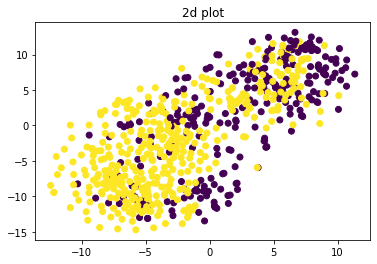

<Figure size 432x288 with 0 Axes>

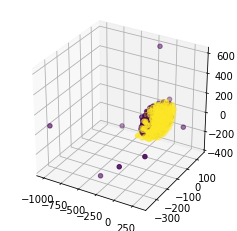

In [123]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  


accuracies=np.zeros(5)
cv = KFold(n_splits=5, random_state=30, shuffle=False)
count=0
for train_index, test_index in cv.split(X):
    count=count+1
    train, test, train_label, test_label = X[train_index], X[test_index], Y[train_index], Y[test_index]
    clf.fit(train, train_label)
    print(clf.score(test,test_label))
#     accuracies[i]=clf.score(test,test_label)

print(count)
print("Accuracy with respect to 3 fold cross validation:",np.mean(accuracies))


X_TSNE1 = TSNE(n_components=3).fit_transform(X)
X_TSNE2 = TSNE(n_components=2).fit_transform(X)


plt.figure(1)
plt.title("2d plot")
plt.scatter(X_TSNE2[:,0],X_TSNE2[:,1],c=Y)
plt.show()


plt.figure(2)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE1[:,0],X_TSNE1[:,1],X_TSNE1[:,2],c=Y)
plt.show()

    
    
